In [1]:
#%pip install -q --no-warn-conflicts malariagen_data
#%pip install -q --no-warn-conflicts petl

In [ ]:
import allel
import malariagen_data
import pandas as pd
import numpy as np
import petl as ptl

In [ ]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns
import plotly.express as px
import re

In [ ]:
#Mounting Google Drive
import os
#from google.colab import drive
#drive.mount("drive")

# make dir
results_dir = '/home/mkient/Desktop/IR/'
os.makedirs(results_dir, exist_ok=True)
os.chdir(results_dir)
#os.listdir()

In [ ]:
## Importing malariagen data set
ag3 = malariagen_data.Ag3("gs://vo_agam_release_master_us_central1/", pre=True)

## Let's check the the sample set
df_samples=ag3.sample_metadata(sample_sets='3.11', sample_query='country=="Burkina Faso"')
sets = list(df_samples.sample_set.unique())

In [ ]:
## define samples cohorts
cohorts, cohorts_, pop_list, pop_list1 = {}, {}, [],[]
for loca in df_samples.location.unique():
    loca_sample = df_samples.query(f"location == '{loca}'")
    for species in loca_sample.aim_species.unique():
      sp_sample=loca_sample.query(f'aim_species=="{species}"')
      key2 = loca[:4]+'_'+species[:3]
      key3 = loca+'[An. '+species+']'
      cohorts_[key2] = f"country == 'Burkina Faso' and location=='{loca}' and aim_species == '{species}'"
      pop_list1.append(key3)
      for year in sp_sample.year.unique():
        key = loca[:4]+'_'+species[:3]+'_'+str(year)
        key1 = loca+'[An. '+species+' ('+ str(year)+')]'
        cohorts[key] = f"country == 'Burkina Faso' and location=='{loca}' and aim_species == '{species}' and year == {year}"
        pop_list1.append(key1)

## Cohorts size
cohorts_size, cohorts_size_ = {}, {}
for coh in cohorts.keys():
  cohorts_size[coh] = df_samples.query(f'{cohorts[coh]}').shape[0]
for coh in cohorts_.keys():
  cohorts_size_[coh] = df_samples.query(f'{cohorts_[coh]}').shape[0]

In [ ]:
#cohorts

In [ ]:
# define function to find metabolic resiatnce gene cluster in each contig
def get_cnv_gene(region, sample_sets, sample_query, gene):
  cnv_ = ag3.gene_cnv(region = region, sample_sets=sample_sets, sample_query=sample_query)

  ## col names
  columns = ['gene_start', 'gene_end','gene_name', 'gene_description']

  # to def
  df_cnv = cnv_['gene_contig'].to_dataframe()

  # insert other col name
  for col in columns:
    df = cnv_[f'{col}']
    df_cnv.insert(columns.index(f'{col}')+1, f'{col}', df)

  #find gene information
  gcontig, gname, gid, gstart, gend, gene_desc = [],[],[],[], [], []
  for contig,name, id, start, end, desc in zip(df_cnv.gene_contig,df_cnv.gene_name, df_cnv.gene_id, df_cnv.gene_start, df_cnv.gene_end,df_cnv.gene_description):
    if str(name)[:3]==f'{gene}':
      gname.append(name), gid.append(id), gstart.append(start), gend.append(end), gcontig.append(contig), gene_desc.append(desc)

  #create dataFrame
  df_gene = pd.DataFrame(zip(gcontig,gstart, gend, gname, gid, gene_desc), columns=['contig','start','stop', 'name', 'id', 'gene_description'])

  return df_gene

In [ ]:
## function to comput cnv time series frequencies
def ds_freq_tab(ds):
  #extract cohorts into a dataframe
  cohort_vars = [v for v in ds if v.startswith("cohort_")]
  df_cohorts = ds[cohort_vars].to_dataframe()
  df_cohorts.columns = [c.split("cohort_")[1] for c in df_cohorts.columns]

  variant_labels = ds["variant_label"].values
  dfs = []
  for cohort_index, cohort in enumerate(df_cohorts.itertuples()):
    ds_cohort = ds.isel(cohorts=cohort_index)
    dict_df =  {"taxon": cohort.taxon, "area": cohort.area, "date": cohort.period_start, "period": str(cohort.period),
                "sample_size": cohort.size,"variant": variant_labels, "count": ds_cohort["event_count"].values,"nobs": ds_cohort["event_nobs"].values,
                "frequency": ds_cohort["event_frequency"].values, "frequency_ci_low": ds_cohort["event_frequency_ci_low"].values,
                "frequency_ci_upp": ds_cohort["event_frequency_ci_upp"].values
                }
    df = pd.DataFrame(dict_df)
    dfs.append(df)

  df_events = pd.concat(dfs, axis=0).reset_index(drop=True)
  df_events = df_events.query("nobs > 0")

  # Frequencies stats
  frq = df_events["frequency"]
  frq_ci_low = df_events["frequency_ci_low"]
  frq_ci_upp = df_events["frequency_ci_upp"]
  df_events["frequency_error"] = frq_ci_upp - frq
  df_events["frequency_error_minus"] = frq - frq_ci_low

  return df_events

In [ ]:
## function to plot cnv times series frq
def plot_freq_time_series(data, height=450, width=900, template='plotly_white', title='CNV frequencies'):

  #plot time series frequencies
  fig = px.line(data, facet_row="area", x="date", y="frequency", error_y="frequency_error",
                error_y_minus="frequency_error_minus", color="variant", markers=True,
                height=height,width=width,template=template, title=title,
                labels={"date": "Year", "frequency": "Allelic frequencies", "variant":'Variants'})

  # figure layout
  fig.update_layout(xaxis=dict(showgrid=False, showline=True, linewidth=1, linecolor='black'),
                   yaxis=dict(showgrid=False, showline=True, linewidth=1, linecolor='gray'))
  fig.update_yaxes(range=[0, 1.0], ticks="outside", col=1)
  fig.update_xaxes(ticks="outside", col=1)

  return fig

In [ ]:
## esterase,
cnv_ls = []
df_esterase, df_gste, df_cyp, region = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), ['X', '2R', '2L', '3R', '3L']
for item in region:
  df_gene = get_cnv_gene(region=f'{item}', sample_sets=sets, sample_query='country=="Burkina Faso"', gene='COE')
  if df_gene.empty == False:
    cnv_ls.append(df_gene)
df_esterase = pd.concat(cnv_ls)

## Gste
cnv_ls = []
for item in region:
  df_gene = get_cnv_gene(region=f'{item}', sample_sets=sets, sample_query='country=="Burkina Faso"', gene='GST')
  if df_gene.empty == False:
    cnv_ls.append(df_gene)
df_gste = pd.concat(cnv_ls)

## Cyp P450
cnv_ls = []
for item in region:
  df_gene = get_cnv_gene(region=f'{item}', sample_sets=sets, sample_query='country=="Burkina Faso"', gene='CYP')
  if df_gene.empty == False:
    cnv_ls.append(df_gene)
df_cyp = pd.concat(cnv_ls)

In [ ]:
coe_id_list = list(df_esterase.id)
gste_id_lit = list(df_gste.id)
cyp_id_list = list(df_cyp.id)

In [ ]:
## genomic region
#cyp6aap_region = "2R:28,480,000-28,510,000"
#cyp9k1_region = "X:15,240,000-15,250,000"
#cyp6mz_region = "3R:6,924,000-6,980,000"
#gste_region = "3R:28,590,000-28,610,000"
#cohorts = "admin1_year"

In [ ]:
## compute cnv frequencies in each gene cluster
coe_cnv_freq = ag3.gene_cnv_frequencies(
    region=coe_id_list,
    cohorts=cohorts,
    sample_sets=sets,
    sample_query='country=="Burkina Faso"',
    )
gste_cnv_freq = ag3.gene_cnv_frequencies(
    region=gste_id_lit,
    cohorts=cohorts,
    sample_sets=sets,
    sample_query='country=="Burkina Faso"',
    )
cyp_cnv_freq = ag3.gene_cnv_frequencies(
    region=cyp_id_list,
    cohorts=cohorts,
    sample_sets=sets,
    sample_query='country=="Burkina Faso"',
    )

In [ ]:
## compute time serie cnv frequencies
gste_cnv_freq_ts = ag3.gene_cnv_frequencies_advanced(
    region=gste_id_lit,
    area_by="location",
    period_by="year",
    sample_sets=sets,
    sample_query="country == 'Burkina Faso'",
    variant_query="max_af > 0.05"
    )
cyp_cnv_freq_ts = ag3.gene_cnv_frequencies_advanced(
    region=cyp_id_list,
    area_by="location",
    period_by="year",
    sample_sets=sets,
    sample_query="country == 'Burkina Faso'",
    variant_query="max_af > 0.05"
    )
coe_cnv_freq_ts = ag3.gene_cnv_frequencies_advanced(
    region=coe_id_list,
    area_by="location",
    period_by="year",
    sample_sets=sets,
    sample_query="country == 'Burkina Faso'",
    variant_query="max_af > 0.05"
    )

# warping to freq tab
df_events_cyp = ds_freq_tab(cyp_cnv_freq_ts)
df_events_gste = ds_freq_tab(gste_cnv_freq_ts)
df_events_coe = ds_freq_tab(coe_cnv_freq_ts)

## add new columns - populations
df_events_cyp['populations']=[str(x)[:4]+'_'+str(y)[:4]+'_'+str(z) for x,y,z in zip(df_events_cyp.area,df_events_cyp.taxon,df_events_cyp.period)]
df_events_gste['populations']=[str(x)[:4]+'_'+str(y)[:4]+'_'+str(z) for x,y,z in zip(df_events_gste.area,df_events_gste.taxon,df_events_gste.period)]
df_events_coe['populations']=[str(x)[:4]+'_'+str(y)[:4]+'_'+str(z) for x,y,z in zip(df_events_coe.area,df_events_coe.taxon,df_events_coe.period)]

In [ ]:
# data warping
#df_events_cyp['populations']=[str(x)[:4]+'_'+str(y)[:4]+'_'+str(z) for x,y,z in zip(df_events_cyp.area,df_events_cyp.taxon,df_events_cyp.period)]
#df_events_gste['populations']=[str(x)[:4]+'_'+str(y)[:4]+'_'+str(z) for x,y,z in zip(df_events_gste.area,df_events_gste.taxon,df_events_gste.period)]
#df_events_coe['populations']=[str(x)[:4]+'_'+str(y)[:4]+'_'+str(z) for x,y,z in zip(df_events_coe.area,df_events_coe.taxon,df_events_coe.period)]

## data warping

In [ ]:
## COE variants
df_coe1=df_events_coe.copy()
df_samples=ag3.sample_metadata(sample_sets='3.11', sample_query='country=="Burkina Faso"')
df_items = df_samples.groupby(['location','latitude','longitude']).size()
lon_lat = {}
for key in df_items.to_dict().keys():
  lon_lat[key[0]]=key[1:]
latitude, longitude = [],[]
df_coe2=df_coe1.sort_values(by='area')
for zone in df_coe2.area.unique():
  if zone in lon_lat.keys():
    print(True, zone,lon_lat[zone][0],lon_lat[zone][1])
  else:
    print(False)
  for z in [itex for itex in range(df_coe2.query(f'area=="{zone}"').shape[0])]:
    latitude.append(lon_lat[zone][0])
    longitude.append(lon_lat[zone][1])

print(len(latitude),len(longitude), df_coe2.shape)

df_coe2['LAT']=latitude
df_coe2['LON']=longitude

df_coe2['CNV'] = [re.split(r' \(|\) ', var)[1]+'_'+re.split(r' \(|\) ', var)[2] for var in df_coe2.variant]

In [ ]:
df_coe3 = pd.pivot_table(df_coe2.query('CNV in ["COEAE6O_amp", "COEJHE3E_amp"]'), values=['count'], columns=['CNV'], index=['populations','area','taxon','LAT','LON','nobs']).droplevel(0, axis=1).reset_index()
df_coe3.set_index('populations', inplace=True)
#df_coe3

In [ ]:
## GSTE variants
df_gste1=df_events_gste.copy()
df_samples=ag3.sample_metadata(sample_sets='3.11', sample_query='country=="Burkina Faso"')
df_items = df_samples.groupby(['location','latitude','longitude']).size()
lon_lat = {}
for key in df_items.to_dict().keys():
  lon_lat[key[0]]=key[1:]
latitude, longitude = [],[]
df_gste2=df_gste1.sort_values(by='area')
for zone in df_gste2.area.unique():
  if zone in lon_lat.keys():
    print(True, zone,lon_lat[zone][0],lon_lat[zone][1])
  else:
    print(False)
  for z in [itex for itex in range(df_gste2.query(f'area=="{zone}"').shape[0])]:
    latitude.append(lon_lat[zone][0])
    longitude.append(lon_lat[zone][1])

print(len(latitude),len(longitude), df_gste2.shape)

df_gste2['LAT']=latitude
df_gste2['LON']=longitude

df_gste2['CNV'] = [re.split(r' \(|\) ', var)[1]+'_'+re.split(r' \(|\) ', var)[2] if len(var.split(' '))==3 else var.split(' ')[0]+'_'+var.split(' ')[1]  for var in df_gste2.variant]

True Bana Village 11.234 -4.473
True Gama 12.003 1.762
True Nagare 12.927 -0.142
True Nassan 13.028 -3.014
True Ouro-Hesso 14.375 -0.128
True Po-Dongo 11.219 -1.02
True Sideradougou 10.678 -4.256
True Souroukoudinga 11.236 -4.537
286 286 (286, 14)


In [ ]:
#df_gste3 = pd.pivot_table(df_gste2, values=['count'], columns=['CNV'], index=['populations','area','taxon','LAT','LON','nobs']).droplevel(0, axis=1).reset_index()
#df4_ace1 = pd.pivot_table(df3_ace1, values=['count'], columns=['aa_change'], index=['area','lat','lon','nobs']).droplevel(0, axis=1).reset_index()
#df_gste3.set_index('populations', inplace=True)

In [ ]:
## CYP variants
df_cyp1=df_events_cyp.copy()
df_samples=ag3.sample_metadata(sample_sets='3.11', sample_query='country=="Burkina Faso"')
df_items = df_samples.groupby(['location','latitude','longitude']).size()
lon_lat = {}
for key in df_items.to_dict().keys():
  lon_lat[key[0]]=key[1:]
latitude, longitude = [],[]
df_cyp2=df_cyp1.sort_values(by='area')
for zone in df_cyp2.area.unique():
  if zone in lon_lat.keys():
    print(True, zone,lon_lat[zone][0],lon_lat[zone][1])
  else:
    print(False)
  for z in [itex for itex in range(df_cyp2.query(f'area=="{zone}"').shape[0])]:
    latitude.append(lon_lat[zone][0])
    longitude.append(lon_lat[zone][1])

print(len(latitude),len(longitude), df_cyp2.shape)

df_cyp2['LAT']=latitude
df_cyp2['LON']=longitude

df_cyp2['CNV'] = [re.split(r' \(|\) ', var)[1]+'_'+re.split(r' \(|\) ', var)[2] if len(var.split(' '))==3 else var.split(' ')[0]+'_'+var.split(' ')[1]  for var in df_cyp2.variant]

True Bana Village 11.234 -4.473
True Gama 12.003 1.762
True Nagare 12.927 -0.142
True Nassan 13.028 -3.014
True Ouro-Hesso 14.375 -0.128
True Po-Dongo 11.219 -1.02
True Sideradougou 10.678 -4.256
True Souroukoudinga 11.236 -4.537
1183 1183 (1183, 14)


In [ ]:
### select and concat CNV tables
df_coe_sub = df_coe2.query('CNV in ["COEAE6O_amp", "COEJHE3E_amp"]')
df_gste_sub = df_gste2.query('CNV in ["GSTD5_del","GSTE1_amp","GSTE2_amp"]')

cyp_list_sel = ['CYP9K1', 'CYP6P3','CYP6P3','CYP6P5','CYP6P4','CYP6P1','CYP6P2','CYP6AA1','CYP6AA2','CYP6P15P',
                'CYP6Z3','CYP6Z2','CYP6Z2','CYP6Z1','CYP9M1','CYP9M1','CYP9M2','CYP6AF1','CYP6AF2','CYP6AF2','CYP12F3','CYP12F2']
sel_cnv = [i for i in df_cyp2.query('frequency>0.2').CNV.unique() if i.split('_')[0] in cyp_list_sel]
df_cyp_sub = df_cyp2.query('CNV in @sel_cnv')

CNV_df = pd.concat([df_coe_sub,df_gste_sub,df_cyp_sub])

## Pivot tables
CNV_df1 = pd.pivot_table(CNV_df, values=['count'], columns=['CNV'], index=['populations','area','taxon','LAT','LON','nobs']).droplevel(0, axis=1).reset_index()
CNV_df1.set_index('populations', inplace=True)
CNV_df1.to_excel(f'{results_dir}/sanger_analyses/resistance/CNV/data/CNV_df1.xlsx')

In [ ]:
#CNV_df1

In [ ]:
## def columns
freq_columns = [col for col in cyp_cnv_freq.columns if col.startswith('frq_')]
#freq_columns

In [ ]:
## def columns
freq_columns = [col for col in cyp_cnv_freq.columns if col.startswith('frq_')]

## remove unamed gene data
cyp_cnv_frq = cyp_cnv_freq.reset_index().query('gene_name.notna()', engine='python')
coe_cnv_frq = coe_cnv_freq.reset_index().query('gene_name.notna()', engine='python')
gste_cnv_frq = gste_cnv_freq.reset_index().query('gene_name.notna()', engine='python')

In [ ]:
## save data to csv
coe_cnv_frq.to_csv(f'{results_dir}/sanger_analyses/resistance/CNV/data/coe_cnv_frq.csv')
cyp_cnv_frq.to_csv(f'{results_dir}/sanger_analyses/resistance/CNV/data/cyp_cnv_frq.csv')
gste_cnv_frq.to_csv(f'{results_dir}/sanger_analyses/resistance/CNV/data/gste_cnv_frq.csv')

In [ ]:
## read data
coe_cnv_frq = pd.read_csv(f'{results_dir}/sanger_analyses/resistance/CNV/data/coe_cnv_frq.csv')
cyp_cnv_frq = pd.read_csv(f'{results_dir}/sanger_analyses/resistance/CNV/data/cyp_cnv_frq.csv')
gste_cnv_frq = pd.read_csv(f'{results_dir}/sanger_analyses/resistance/CNV/data/gste_cnv_frq.csv')

In [ ]:
#gste_cnv_frq#.columns

In [ ]:
freq_columns = ['frq_Po-D_ara_2022','frq_Nass_ara_2022','frq_Side_gam_2022',
                'frq_Po-D_gam_2022','frq_Gama_gam_2022','frq_Naga_gam_2022',
                'frq_Bana_col_2022', 'frq_Sour_col_2022',  'frq_Po-D_col_2022',
                'frq_Gama_col_2022', 'frq_Nass_col_2022',  'frq_Naga_col_2022',
                 'frq_Ouro_col_2022']

col_lab = ['An. arabiensis (Po-D)', 'An. arabiensis (Nass)', 'An. gambiae ss (Side)',
           'An. gambiae ss (Po-D)', 'An. gambiae ss (Gama)', 'An. gambiae ss (Naga)',
           'An. coluzzii (Bana)', 'An. coluzzii (Sour)', 'An. coluzzii (Po-D)',
           'An. coluzzii (Gama)', 'An. coluzzii (Nass)', 'An. coluzzii (Naga)',
           'An. coluzzii (Ouro)']
loc_lab = ['Po-Dongo','Nassan','Sideradougou','Po-Dongo','Gama','Nagare',
           'Bana','Souroukoudinga','Po-Dongo','Gama','Nassan','Nagare','Ouro-Hesso']

# Analysing esterase frequencies

<ipython-input-22-b4b3f7301b92>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


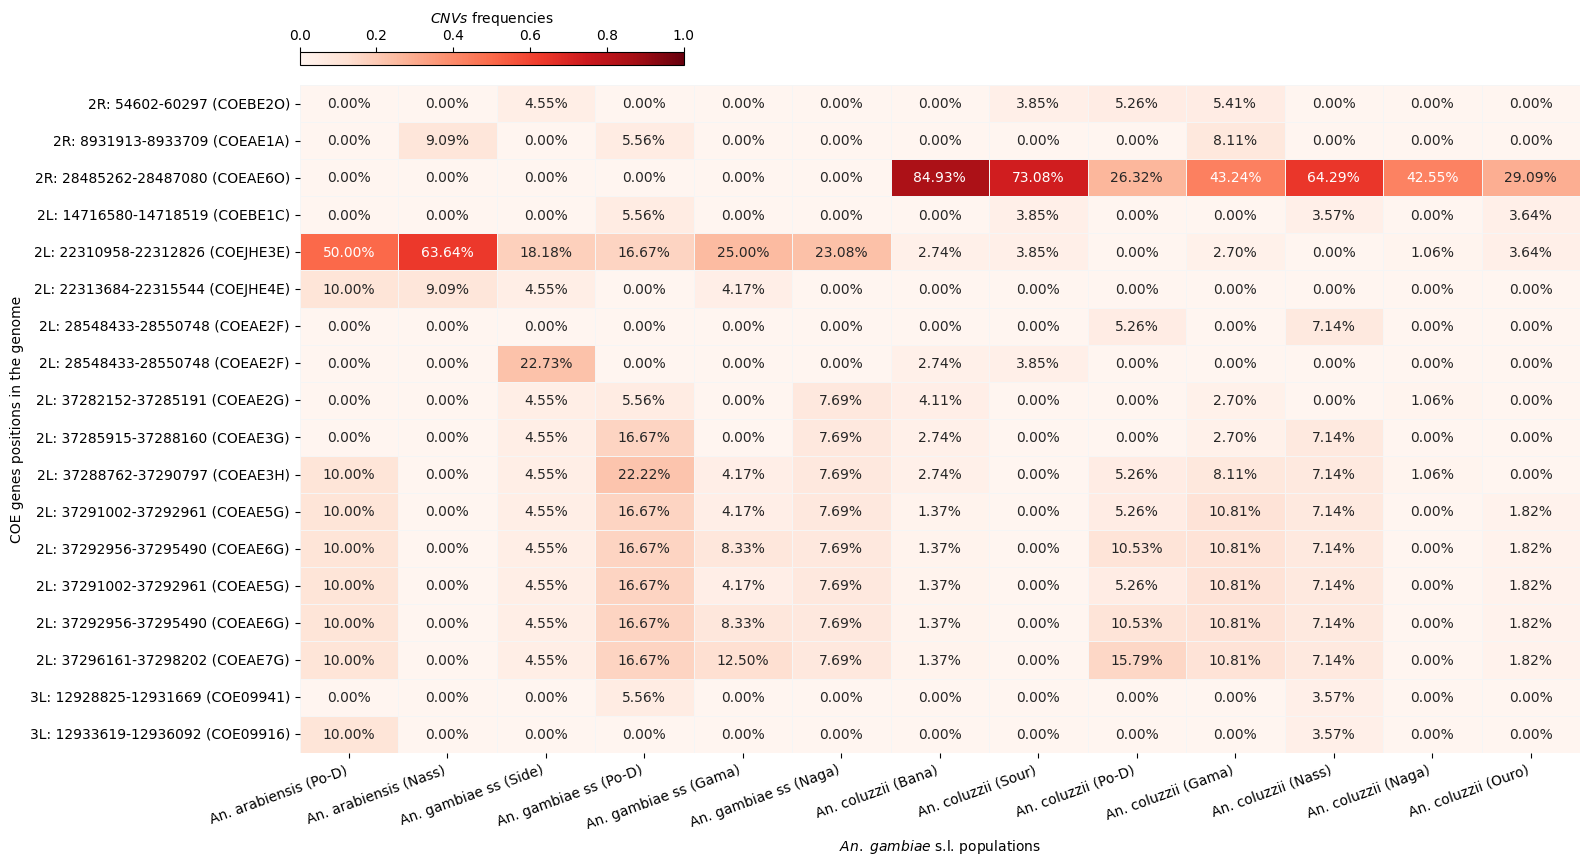

In [ ]:
# plot allele freqs per pop
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(16,8))
#sns.set(font_scale = 1)
#Selecting data
select_coe = coe_cnv_frq.query('max_af > 0.05')
ptl_df_coe = ptl.fromdataframe(select_coe)

#set labels
labels = ['%s: %s-%s (%s)' % (rec.contig, rec.start, rec.end, rec.gene_name) for rec in ptl_df_coe.records()]
color_2 = sns.color_palette("Reds", as_cmap=True)

# plot
ax=sns.heatmap(select_coe[freq_columns], vmin=0, vmax=1, fmt='.2%', cmap=color_2, yticklabels=labels,
               xticklabels=col_lab, linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
plt.xticks(rotation=20, ha='right')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = 'COE genes positions in the genome')

cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.03, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$CNVs$ frequencies')

fig.tight_layout()


<ipython-input-120-226d0855b910>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


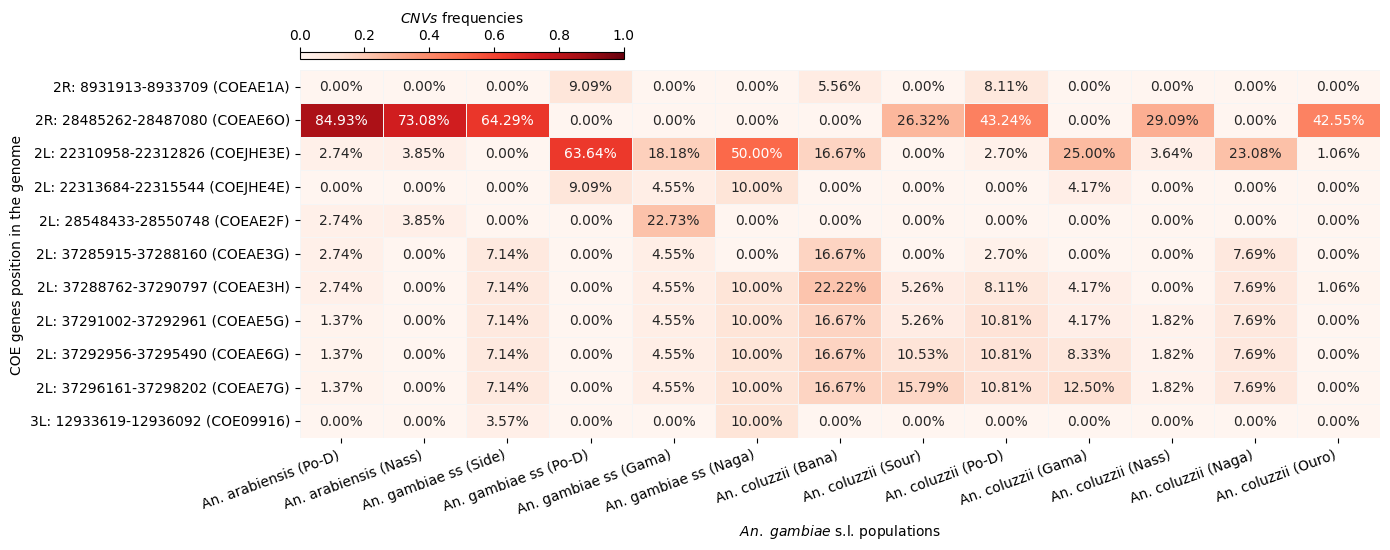

In [ ]:
# plot allele freqs per pop
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(14,5))
#sns.set(font_scale = 1)
#Selecting data
select_coe = coe_cnv_frq.query('max_af > 0.08')
select_coe = select_coe.drop_duplicates(subset=['gene_id', 'gene_name', 'cnv_type', 'start', 'end'])
ptl_df_coe = ptl.fromdataframe(select_coe)

#set labels
labels = ['%s: %s-%s (%s)' % (rec.contig, rec.start, rec.end, rec.gene_name) for rec in ptl_df_coe.records()]
color_2 = sns.color_palette("Reds", as_cmap=True)

## xlab and col
col_select = freq_columns.copy()

# plot
ax=sns.heatmap(select_coe[freq_columns], vmin=0, vmax=1, fmt='.2%', cmap=color_2, yticklabels=labels,
               xticklabels=col_lab, linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
plt.xticks(rotation=20, ha='right')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = 'COE genes position in the genome')

cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.03, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$CNVs$ frequencies')

fig.tight_layout()

<ipython-input-96-2cba0f32de6c>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


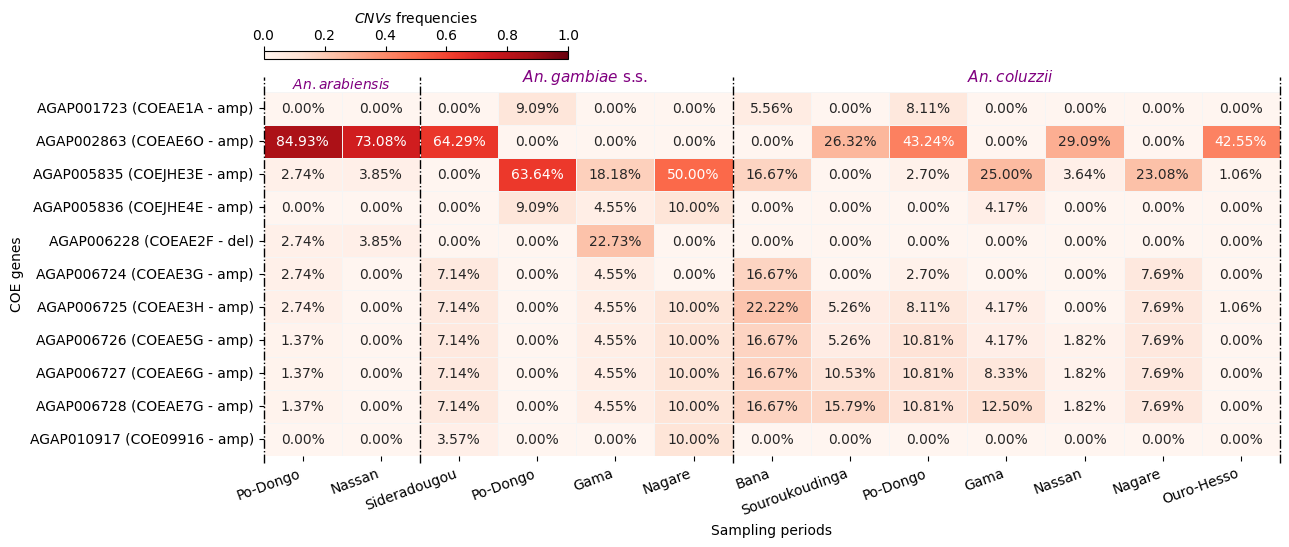

In [ ]:
# plot allele freqs per pop
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(13,5))
#sns.set(font_scale = 1)
#Selecting data
select_coe = coe_cnv_frq.query('max_af > 0.08')
select_coe = select_coe.drop_duplicates(subset=['gene_id', 'gene_name', 'cnv_type', 'start', 'end'])
ptl_df_coe = ptl.fromdataframe(select_coe)

#set labels
labels = ['%s (%s - %s)' % (rec.gene_id, rec.gene_name, rec.cnv_type) for rec in ptl_df_coe.records()]
color_2 = sns.color_palette("Reds", as_cmap=True)

## xlab and col
#col_select = freq_columns.copy()
#col_select.remove('frq_BF-09_arab_2015')
#xlab = col_lab.copy()
#xlab.remove('An. arabiensis (2015)')

# plot
ax=sns.heatmap(select_coe[freq_columns], vmin=0, vmax=1, fmt='.2%', cmap=color_2, yticklabels=labels,
               xticklabels=loc_lab, linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
plt.xticks(rotation=20, ha='right')

## line to separate samples
plt.axvline(x=0, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)
plt.axvline(x=2, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)
plt.axvline(x=6, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)
plt.axvline(x=13, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)

##Text
plt.text(1, -0.1, '$An. arabiensis$', ha = 'center', size=10, color='purple')
plt.text(3.3, -0.3, '$An. gambiae$'+' s.s.', size=11, color='purple')
plt.text(9, -0.3, '$An. coluzzii$', size=11, color='purple')

## ax label
ax.set_xlabel("Sampling periods")
ax.set_ylabel('COE genes')

## Legend## Legend
cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.09, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$CNVs$ frequencies')

fig.tight_layout()

#fig.savefig(f'{results_dir}/sanger_analyses/resistance/CNV/cnv_coe.png', dpi=300, bbox_inches='tight')


#Analysing gste frequencies

<ipython-input-25-834bed02d125>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


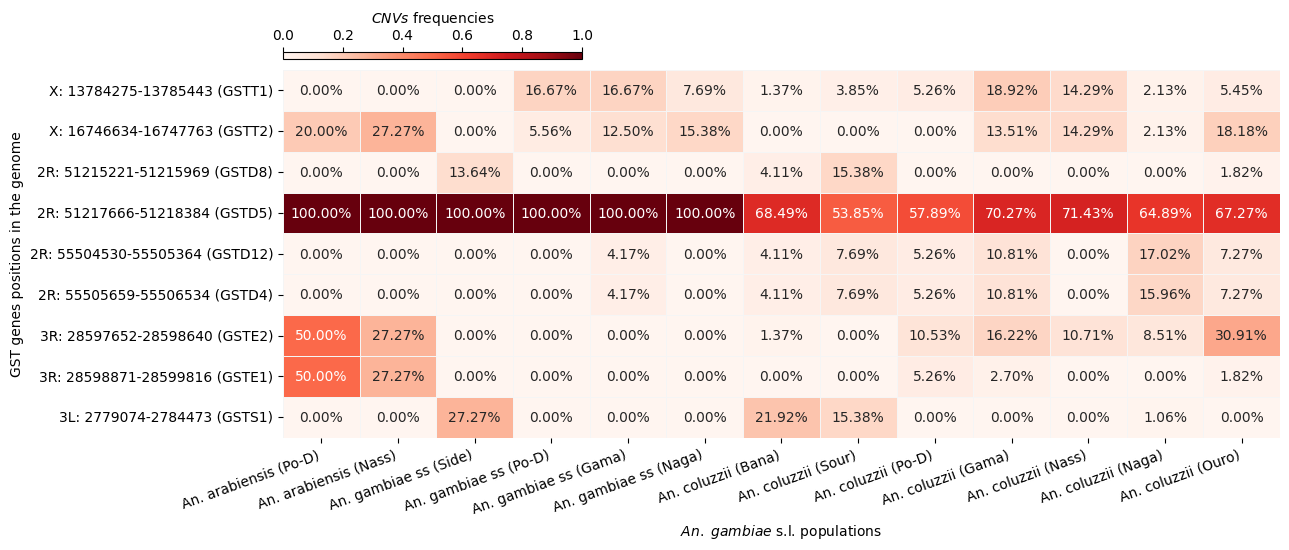

In [ ]:
# plot allele freqs per pop
fig = plt.figure(figsize=(13,5))
#Selecting data
select_gste = gste_cnv_frq.query('max_af > 0.15')
ptl_df_gste = ptl.fromdataframe(select_gste)

#set labels
labels = ['%s: %s-%s (%s)' % (rec.contig, rec.start, rec.end, rec.gene_name) for rec in ptl_df_gste.records()]
color_2 = sns.color_palette("Reds", as_cmap=True)

# plot
ax=sns.heatmap(select_gste[freq_columns], vmin=0, vmax=1, fmt='.2%', cmap=color_2, yticklabels=labels,
               xticklabels=col_lab, linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
plt.xticks(rotation=20, ha='right')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = 'GST genes positions in the genome')

cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.03, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$CNVs$ frequencies')

fig.tight_layout()

#save fig


<ipython-input-26-5cdccad2a5bc>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


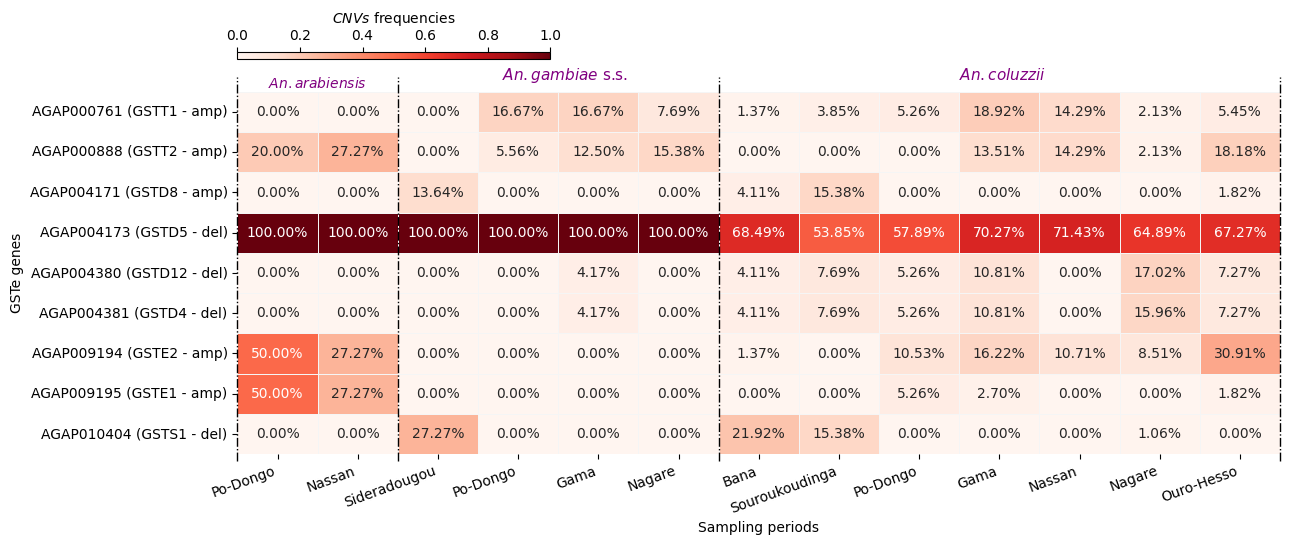

In [ ]:
# plot allele freqs per pop
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(13,5))
#sns.set(font_scale = 1)
#Selecting data
select_gste = gste_cnv_frq.query('max_af > 0.15')
select_gste = select_gste.drop_duplicates(subset=['gene_id', 'gene_name', 'cnv_type', 'start', 'end'])
ptl_df_gste = ptl.fromdataframe(select_gste)

#set labels
labels = ['%s (%s - %s)' % (rec.gene_id, rec.gene_name, rec.cnv_type) for rec in ptl_df_gste.records()]
color_2 = sns.color_palette("Reds", as_cmap=True)

## xlab and col
#col_select = freq_columns.copy()
#col_select.remove('frq_BF-09_arab_2015')
#xlab = col_lab.copy()
#xlab.remove('An. arabiensis (2015)')

# plot
ax=sns.heatmap(select_gste[freq_columns], vmin=0, vmax=1, fmt='.2%', cmap=color_2, yticklabels=labels,
               xticklabels=loc_lab, linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
plt.xticks(rotation=20, ha='right')

## line to separate samples
plt.axvline(x=0, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)
plt.axvline(x=2, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)
plt.axvline(x=6, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)
plt.axvline(x=13, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)

##Text
plt.text(1, -0.1, '$An. arabiensis$', ha = 'center', size=10, color='purple')
plt.text(3.3, -0.3, '$An. gambiae$'+' s.s.', size=11, color='purple')
plt.text(9, -0.3, '$An. coluzzii$', size=11, color='purple')

## ax label
ax.set_xlabel("Sampling periods")
ax.set_ylabel('GSTe genes')

## Legend## Legend
cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.09, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$CNVs$ frequencies')

fig.tight_layout()

fig.savefig(f'{results_dir}/sanger_analyses/resistance/CNV/cnv_gste.png', dpi=300, bbox_inches='tight')


In [ ]:
#gste_cnv_frq.query('max_af > 0.05')

#Analysing cyp frequencies

In [ ]:
cyp_list = list(cyp_cnv_frq.query('max_af > 0.05').gene_name)
print(len(cyp_list))
#cyp_list

85


In [ ]:
cyp_selected_list = ['CYP9K1', 'CYP6P3','CYP6P3','CYP6P5','CYP6P4','CYP6P1','CYP6P2','CYP6AA1','CYP6AA2','CYP6P15P',
                     'CYP6Z3','CYP6Z2','CYP6Z2','CYP6Z1','CYP9M1','CYP9M1','CYP9M2','CYP6AF1','CYP6AF2','CYP6AF2','CYP12F3','CYP12F2','CYP12F2','CYP12F1',]

cyp_list_sel = ['CYP9K1', 'CYP6P3','CYP6P3','CYP6P5','CYP6P4','CYP6P1','CYP6P2','CYP6AA1','CYP6AA2','CYP6P15P',
                'CYP6Z3','CYP6Z2','CYP6Z2','CYP6Z1','CYP9M1','CYP9M1','CYP9M2','CYP6AF1','CYP6AF2','CYP6AF2','CYP12F3','CYP12F2']

In [ ]:
#cyp_cnv_frq.query(f'gene_name == {cyp_selected_list} and max_af > 0.1')

<ipython-input-31-db21a091077c>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


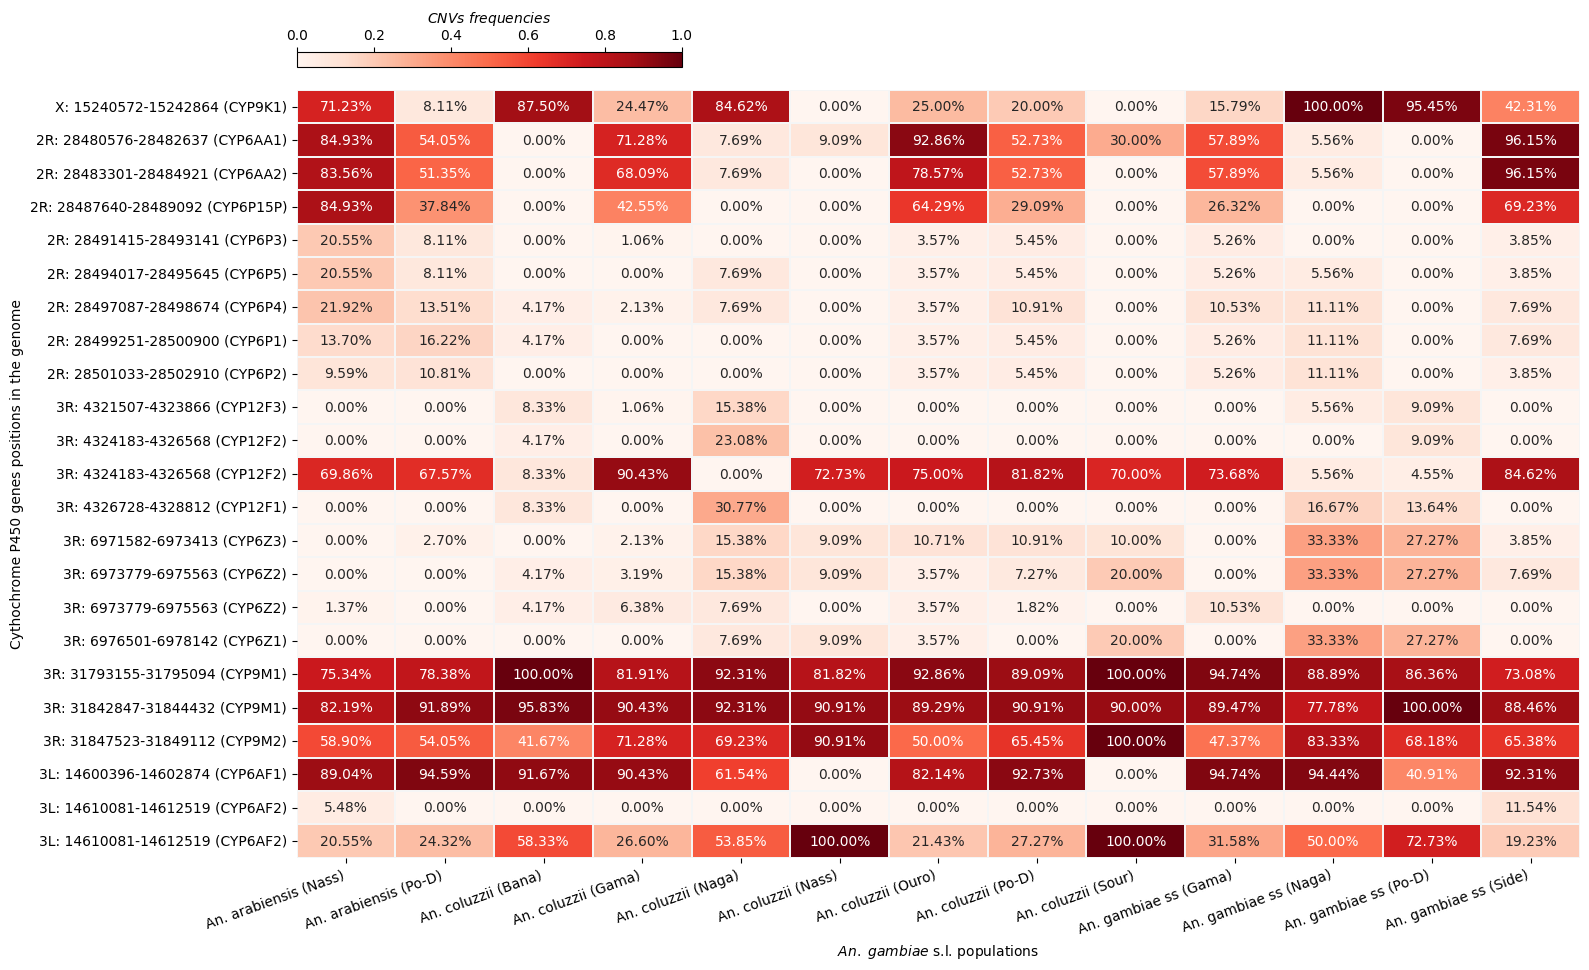

In [ ]:
## Plot allele freqs per pop
fig, ax = plt.subplots(figsize=(16,9))
#sns.set(font_scale = 1)
#Selecting data
select_cyp = cyp_cnv_frq.query(f'gene_name == {cyp_selected_list} and max_af > 0.1')
ptl_df_cyp = ptl.fromdataframe(select_cyp)

#set labels
labels = ['%s: %s-%s (%s)' % (rec.contig, rec.start, rec.end, rec.gene_name) for rec in ptl_df_cyp.records()]
color_2 = sns.color_palette("Reds", as_cmap=True)

# plot
ax=sns.heatmap(select_cyp[sorted(freq_columns)], vmin=0, vmax=1, fmt='.2%', cmap=color_2, yticklabels=labels, linewidths=0.25,
               xticklabels=sorted(col_lab),linecolor="whitesmoke",annot=True, cbar=False)
plt.xticks(rotation=20, ha='right')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = 'Cythochrome P450 genes positions in the genome')

cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.03, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$CNVs$ $frequencies$')

fig.tight_layout()


<ipython-input-99-2d1ea6ab5eae>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


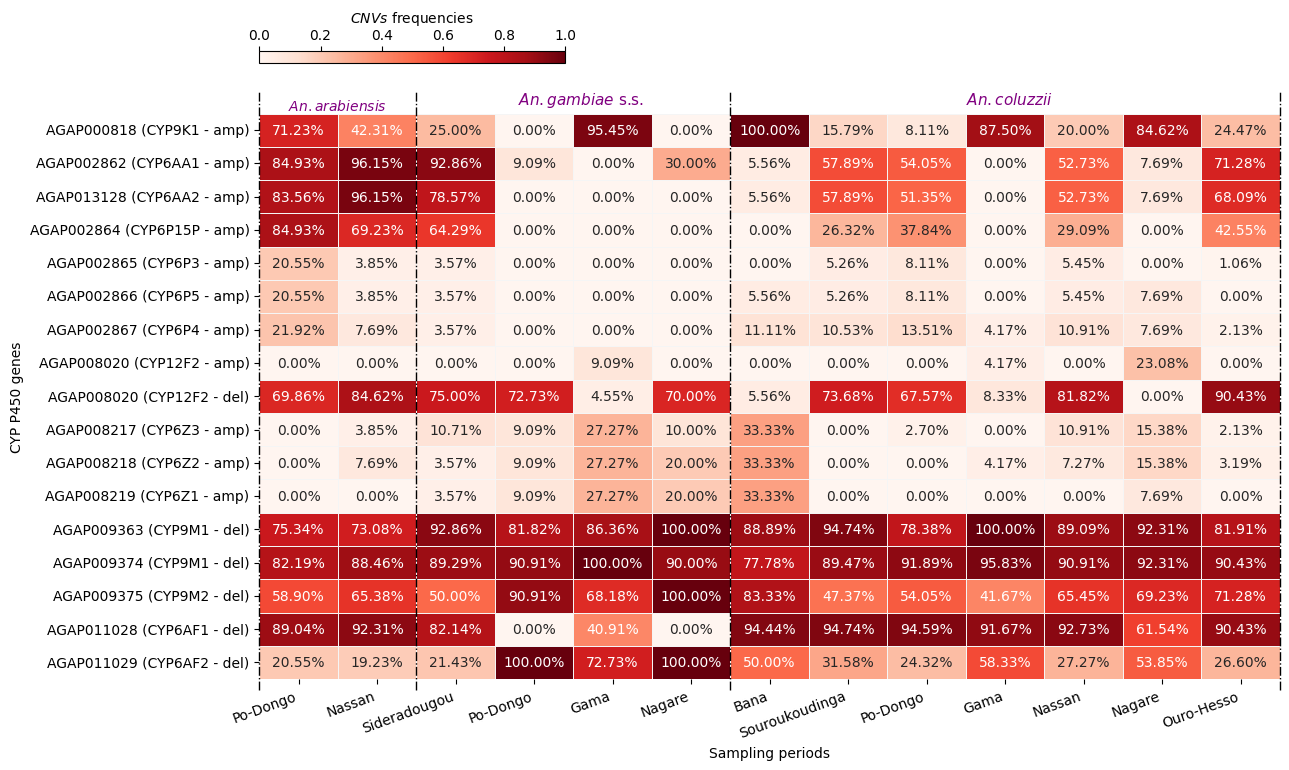

In [ ]:
# plot allele freqs per pop
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(13,7))
#sns.set(font_scale = 1)
#Selecting data
select_cyp = select_cyp = cyp_cnv_frq.query(f'gene_name == {cyp_list_sel} and max_af > 0.2')
select_cyp = select_cyp.drop_duplicates(subset=['gene_id', 'gene_name', 'cnv_type', 'start', 'end'])
ptl_df_cyp = ptl.fromdataframe(select_cyp)

#set labels
labels = ['%s (%s - %s)' % (rec.gene_id, rec.gene_name, rec.cnv_type) for rec in ptl_df_cyp.records()]
color_2 = sns.color_palette("Reds", as_cmap=True)

# plot
ax=sns.heatmap(select_cyp[freq_columns], vmin=0, vmax=1, fmt='.2%', cmap=color_2, yticklabels=labels,
               xticklabels=loc_lab, linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
plt.xticks(rotation=20, ha='right')

## line to separate samples
plt.axvline(x=0, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)
plt.axvline(x=2, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)
plt.axvline(x=6, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)
plt.axvline(x=13, ymin=-0.02, ymax=1.04, ls='dashdot',color='k',clip_on=False,lw=1)

##Text
plt.text(1, -0.1, '$An. arabiensis$', ha = 'center', size=10, color='purple')
plt.text(3.3, -0.3, '$An. gambiae$'+' s.s.', size=11, color='purple')
plt.text(9, -0.3, '$An. coluzzii$', size=11, color='purple')

## ax label
ax.set_xlabel("Sampling periods")
ax.set_ylabel('CYP P450 genes')

## Legend## Legend
cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.09, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$CNVs$ frequencies')

fig.tight_layout()

fig.savefig(f'{results_dir}/sanger_analyses/resistance/CNV/cnv_cyp.png', dpi=300, bbox_inches='tight')